Library Imports

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import random
from cv2 import resize
from glob import glob
import requests
from io import BytesIO

Dataset split

In [93]:

img_height = 244
img_width = 244

train_ds = tf.keras.utils.image_dataset_from_directory(
    './Faulty_solar_panel',  # removed FSD
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    './Faulty_solar_panel',  # removed FSD
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=32
)


Found 889 files belonging to 7 classes.
Using 712 files for training.
Found 889 files belonging to 7 classes.
Using 177 files for validation.


In [94]:
# Checking the Classes 
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered', 'test_images']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

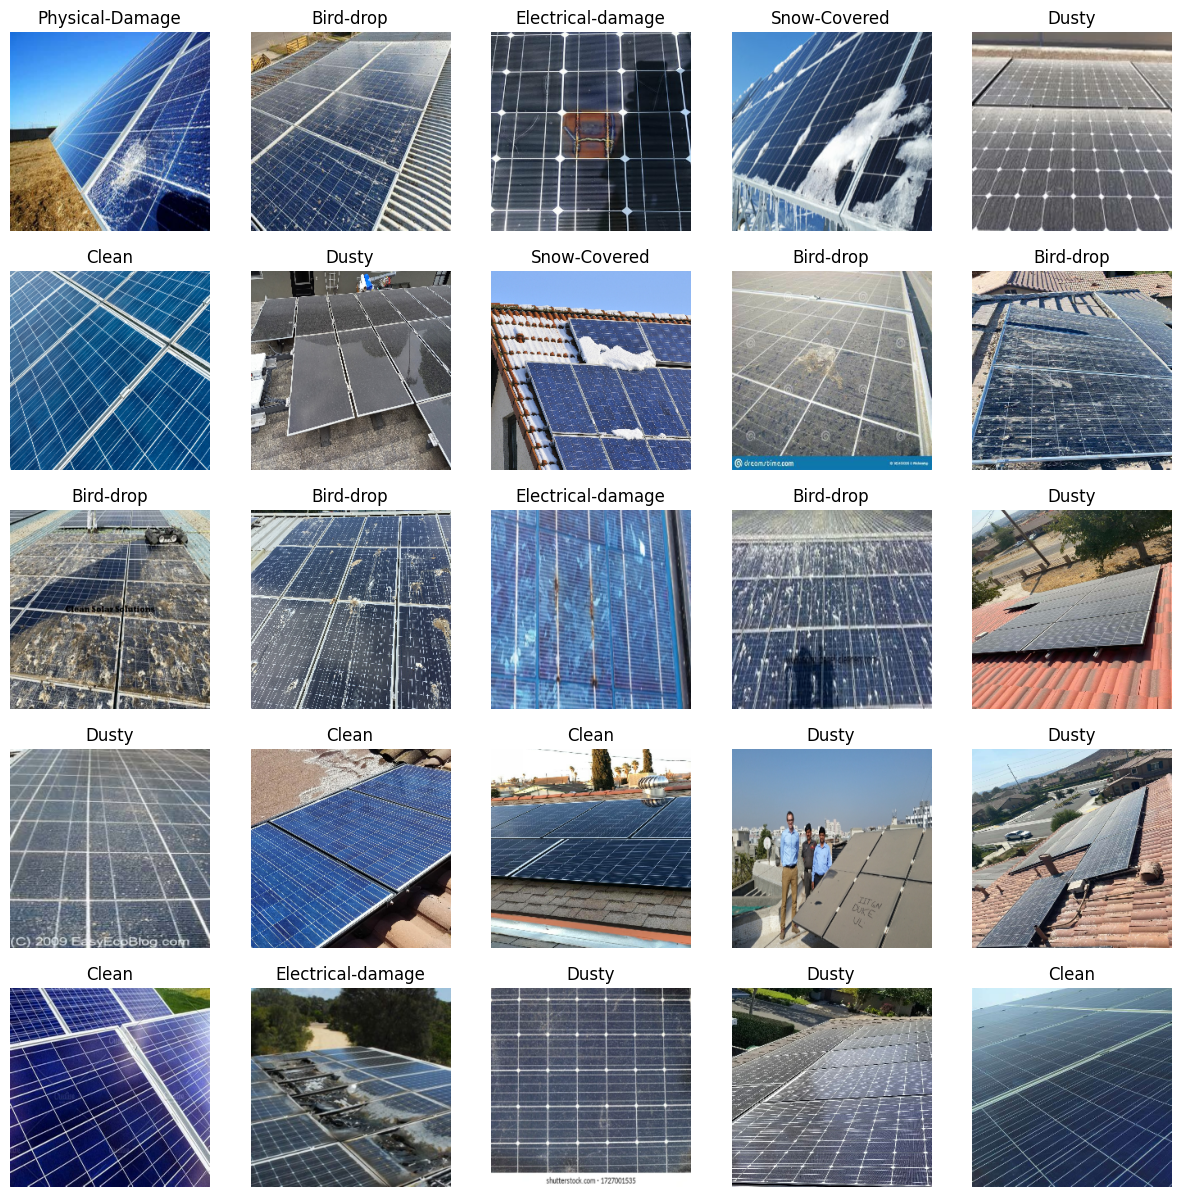

In [95]:
# Checking Training Data
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model definition

In [96]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False 

In [ ]:
from tensorflow.keras.layers import Lambda

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = Lambda(tf.keras.applications.vgg16.preprocess_input)(inputs)  
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)


model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 90)                46170     
                                                          

In [98]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Training

In [99]:
epoch = 20
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
23/23 [==============================] - 138s 6s/step - loss: 8.2738 - accuracy: 0.1250 - val_loss: 3.9634 - val_accuracy: 0.2486
Epoch 2/20
23/23 [==============================] - 135s 6s/step - loss: 4.8237 - accuracy: 0.2795 - val_loss: 2.5862 - val_accuracy: 0.3446
Epoch 3/20
23/23 [==============================] - 144s 6s/step - loss: 3.5469 - accuracy: 0.3876 - val_loss: 1.9776 - val_accuracy: 0.4689
Epoch 4/20
23/23 [==============================] - 145s 6s/step - loss: 2.6867 - accuracy: 0.4508 - val_loss: 1.6542 - val_accuracy: 0.5650
Epoch 5/20
23/23 [==============================] - 209s 9s/step - loss: 2.2180 - accuracy: 0.4986 - val_loss: 1.4889 - val_accuracy: 0.6045
Epoch 6/20
23/23 [==============================] - 214s 9s/step - loss: 2.0110 - accuracy: 0.5576 - val_loss: 1.3060 - val_accuracy: 0.6158
Epoch 7/20
23/23 [==============================] - 157s 7s/step - loss: 1.7589 - accuracy: 0.5463 - val_loss: 1.1046 - val_accuracy: 0.6836
Epoch 8/20
23

In [100]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 90)                46170     
                                                          

In [101]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
epoch = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/20
23/23 [==============================] - 149s 6s/step - loss: 1.0274 - accuracy: 0.6713 - val_loss: 0.6608 - val_accuracy: 0.7740
Epoch 2/20
23/23 [==============================] - 140s 6s/step - loss: 0.3754 - accuracy: 0.8764 - val_loss: 0.5770 - val_accuracy: 0.8362
Epoch 3/20
23/23 [==============================] - 137s 6s/step - loss: 0.2145 - accuracy: 0.9312 - val_loss: 0.5544 - val_accuracy: 0.7966
Epoch 4/20
23/23 [==============================] - 137s 6s/step - loss: 0.1354 - accuracy: 0.9621 - val_loss: 0.5453 - val_accuracy: 0.8362
Epoch 5/20
23/23 [==============================] - 142s 6s/step - loss: 0.1109 - accuracy: 0.9663 - val_loss: 0.4500 - val_accuracy: 0.8588
Epoch 6/20
23/23 [==============================] - 146s 6s/step - loss: 0.0814 - accuracy: 0.9775 - val_loss: 0.5048 - val_accuracy: 0.8475
Epoch 7/20
23/23 [==============================] - 150s 7s/step - loss: 0.0763 - accuracy: 0.9747 - val_loss: 0.7592 - val_accuracy: 0.7853
Epoch 8/20
23

Model Evaluation

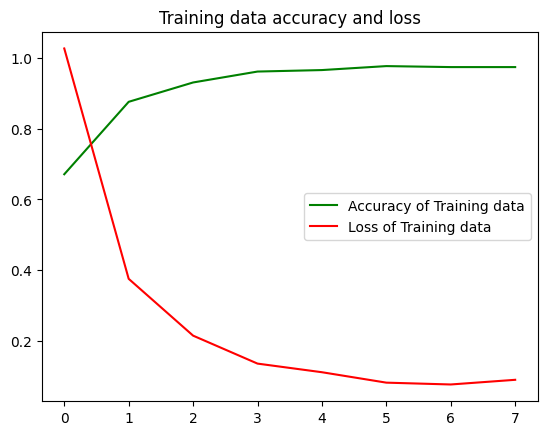

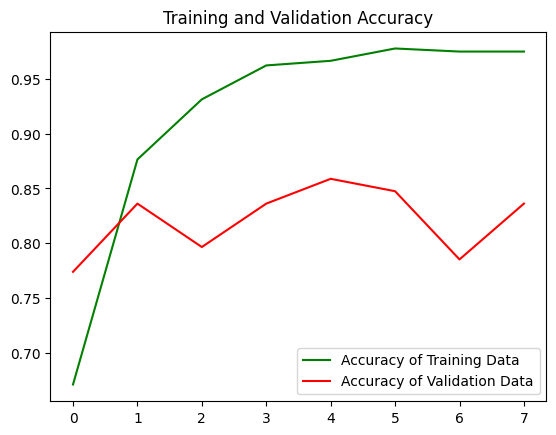

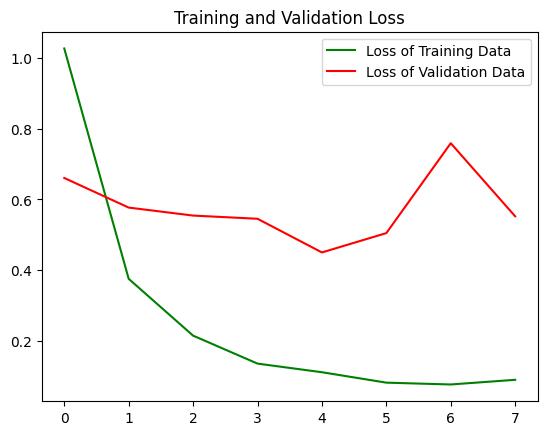

<Figure size 640x480 with 0 Axes>

In [103]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 257ms/step


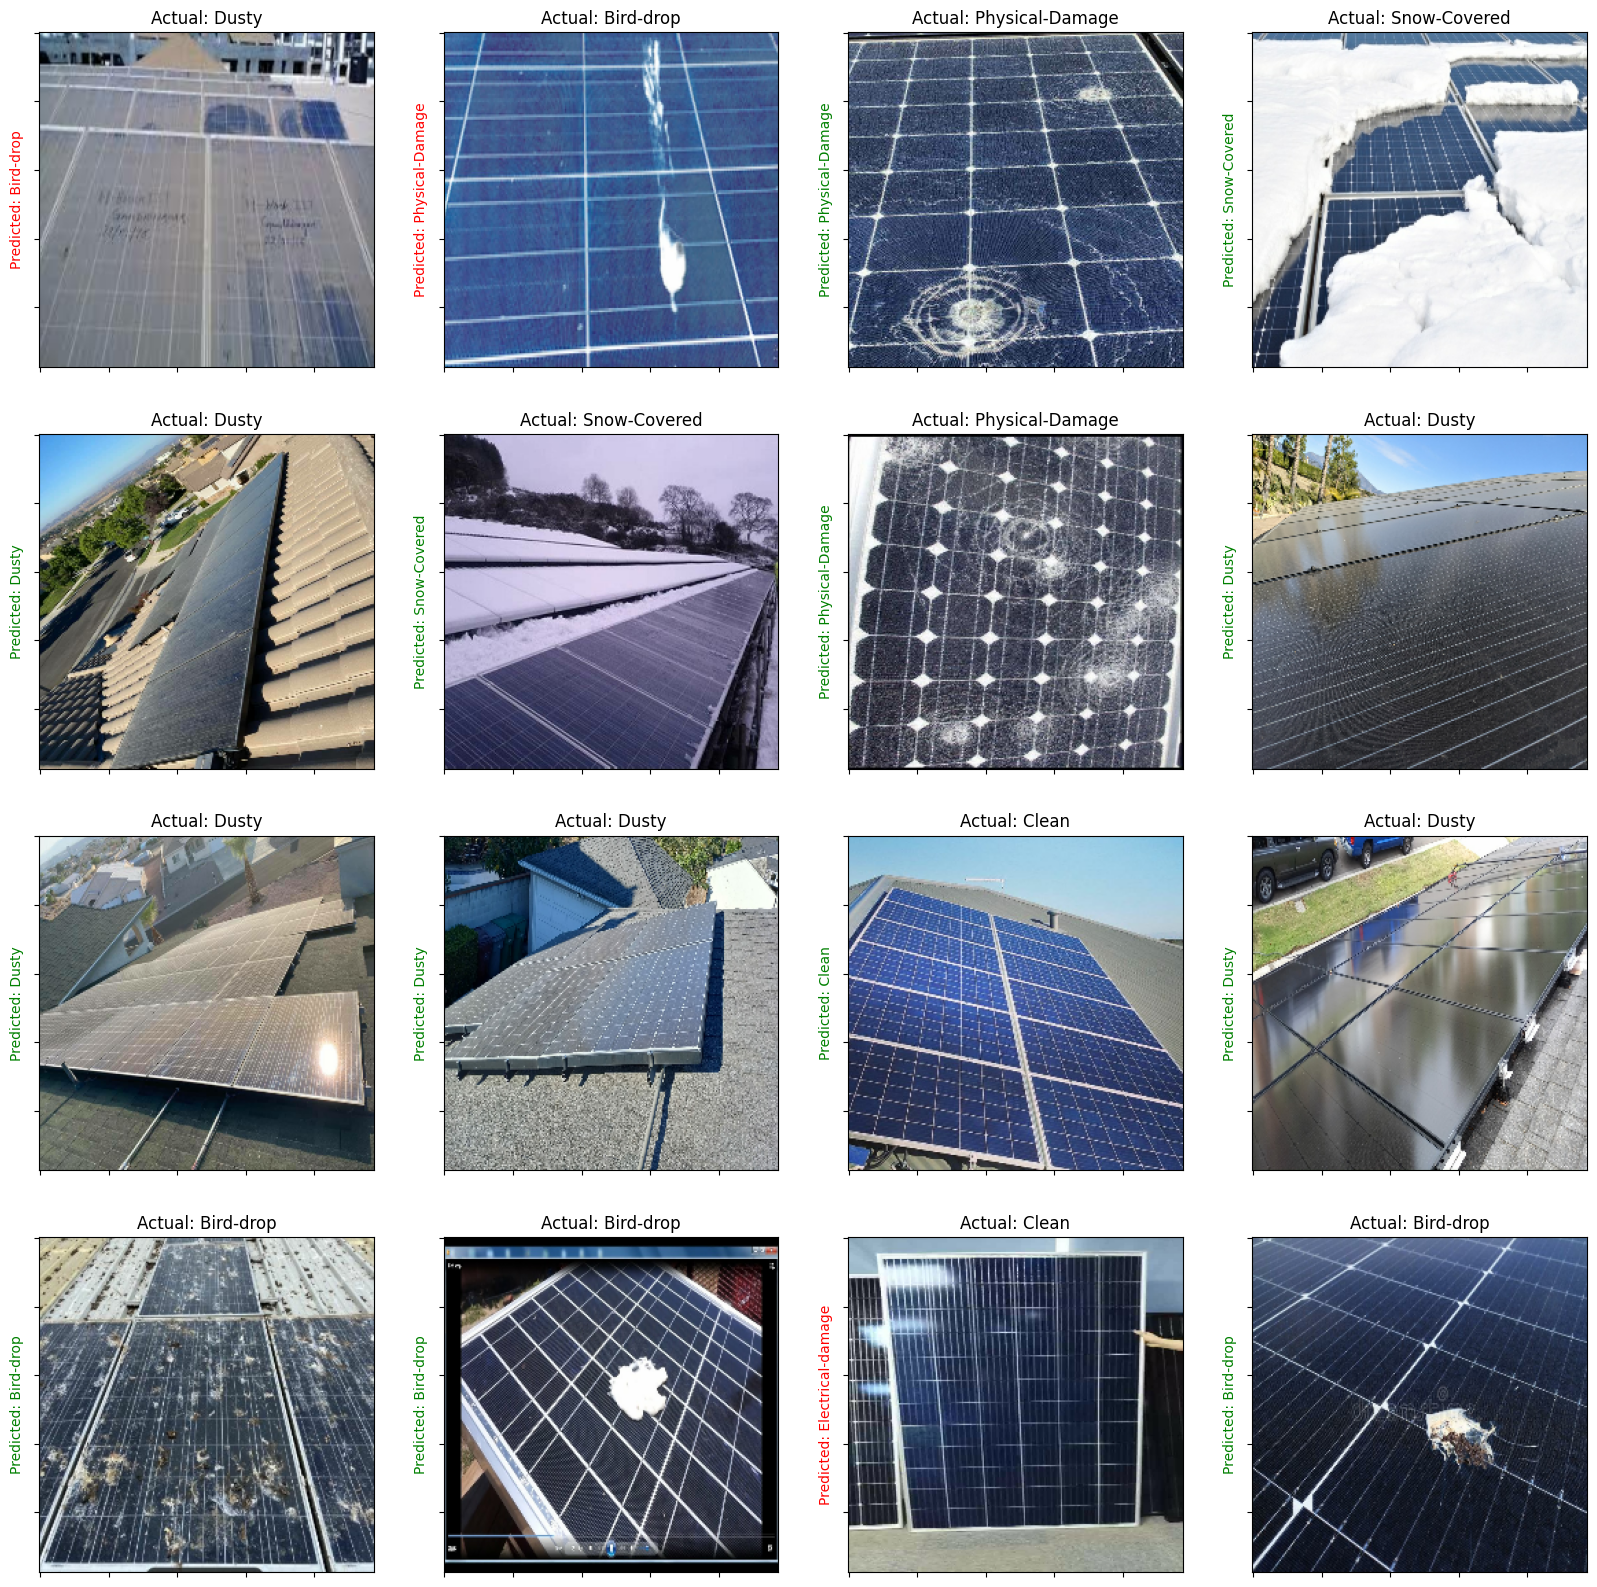

In [104]:
loss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

Using model for prediction

1/1 [==============================] - 0s 213ms/step
Predicted label: test_images


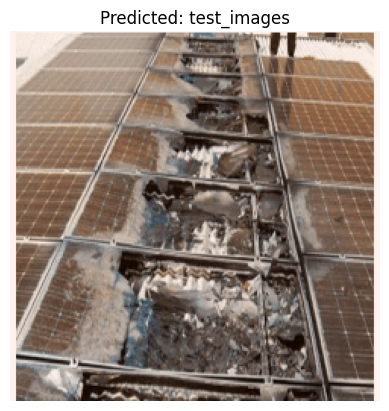

In [105]:
#testing using a downloaded picture from the internet
img_path = 'Faulty_solar_panel/test_images/test_1.png'

# Load the image with the target size
img_height = 244
img_width = 244
img = image.load_img(img_path, target_size=(img_height, img_width))

def model_predict(tf_img,trained_model):
    # Convert the image to a numpy array
    img_array = image.img_to_array(tf_img)

    # Add an extra dimension to the image (required for model input)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image using VGG16's preprocess_input function
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    
    # Predict the class using the model
    predictions = trained_model.predict(img_array)
    
    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class index to the class label
    predicted_label = class_names[predicted_class[0]]
    
    # Print the predicted label
    print(f"Predicted label: {predicted_label}")
    
    # Plot the image with the predicted label
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

model_predict(img,model)

1/1 [==============================] - 0s 170ms/step
Predicted label: Physical-Damage


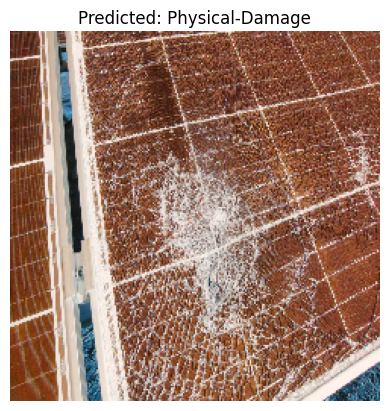

In [106]:
#testing using a downloaded animated picture from the internet
# Define the URL of the image
#img_url ="https://upload.wikimedia.org/wikipedia/commons/7/7e/Solar_Panel_Flat.JPG"
img_url ="https://sistinesolar.com/wp-content/uploads/2023/08/Solar-panel-repair-services.jpg"
# Download the image
response = requests.get(img_url)

img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,model)

1/1 [==============================] - 1s 1s/step
Predicted label: Physical-Damage


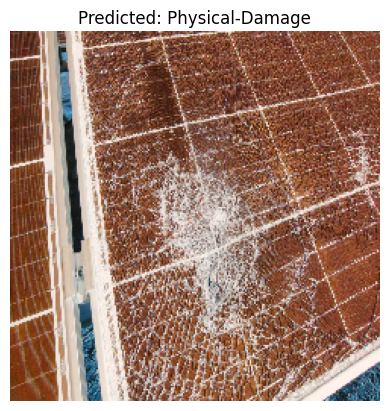

In [121]:
#testing using a downloaded animated picture from the internet
# Define the URL of the image
img_url ="https://sistinesolar.com/wp-content/uploads/2023/08/Solar-panel-repair-services.jpg"
# Download the image
response = requests.get(img_url)

img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,model)

In [122]:
#testing using a downloaded animated picture from the internet
# Define the URL of the image

#testing using direct URL of picture from the internet as a input
img_url =""
response = requests.get(img_url)
img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,model)

MissingSchema: Invalid URL '': No scheme supplied. Perhaps you meant https://?

1/1 [==============================] - 1s 785ms/step
Predicted label: Dusty


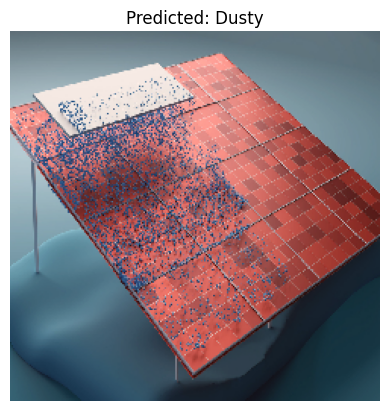

In [116]:
#testing using direct URL of picture from the internet as a input
img_url ='https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/202203/MIT-Cleaning-Solar-01-press_0.jpg'
response = requests.get(img_url)
img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,model)

Exporting and using the model

In [110]:
# Save the model
model.save('SolarPanel_VGG16_Model.keras')

In [111]:
# Load the model with custom objects
loaded_model = tf.keras.models.load_model('SolarPanel_VGG16_Model.keras', safe_mode=False)


1/1 [==============================] - 1s 760ms/step
Predicted label: Dusty


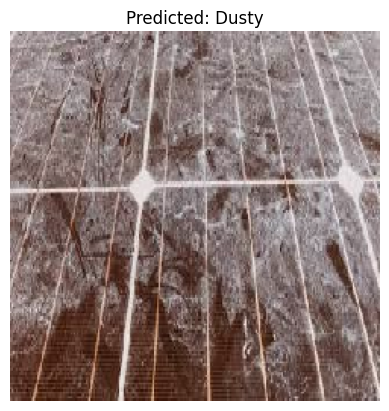

In [123]:
# Define the URL of the image
img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhanSnviSZSTHmrSmO_rNnTJqzrzMiioYa6A&s'

# Download the image
response = requests.get(img_url)
img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

# Predict
model_predict(img, loaded_model)